# Gene mutation analysis

In [1]:
import matplotlib
from matplotlib import pyplot
from statistics import median, mean

# Make the plots used here look kinda like ggplots
pyplot.style.use("ggplot")

# Use a consistent color scheme for relating codon positions to colors.
#
# Uses a hopefully colorblind-friendly grayscale scheme, where CP 1 = black, CP 2 = gray, and CP 3 = white
# (This should be accompanied by black borders around each color so that the gray/white are easily visible on
# a light background).
#
# We also say CP 4 = green (which is not quite as colorblind-friendly... in the future would be good to add a
# pattern or something). I know what you're thinking -- "CP 4? The computer scientists have gone too
# far this time." But don't worry, I know basic biology (hopefully) -- CP 4 here is shorthand that means
# "positions in non-coding regions of the genome", since it can be interesting to summarize these positions
# alongside the CPs.
cp2color = {1: "#000000", 2: "#888888", 3: "#ffffff", 4: "#29D321"}
BORDERCOLOR = "#000000"

# This is the blue color used in the ggplot-style matplotlib color settings: from
# https://gist.github.com/huyng/816622
SCATTERPLOT_PT_COLOR = "#348ABD"

# Maps seq names to easier-to-remember names used in the report.
seq2name = {"edge_6104": "CAMP", "edge_1371": "BUT", "edge_2358": "BACT"}

In [2]:
def use_thousands_sep(mpl_axis):
    # Use thousands separators for positions.
    # For an arbitrary pyplot figure, you can call this function with pyplot.gca().xaxis or pyplot.gca().yaxis. 
    # Modified from https://stackoverflow.com/a/25973637 -- this is modified to work better with integers
    # (matplotlib seems to store all values as floats internally, even essentially integral things -- so we can
    # use the float.is_integer() method to see if a value is "close enough" to an integer, and if so remove the
    # trailing ".0" that happens when you try to format a float of an integer -- see
    # https://stackoverflow.com/a/21583817.)
    mpl_axis.set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, pos: "{:,}".format(int(x)) if x.is_integer() else "{:,}".format(x)
    ))

## Load JSON pileup data

Rather than download plaintext pileup data or a BAM file from Bloom, I converted the BAM file to four JSON files:

- `seq2pos2totalcov.json`: Maps sequence name to a mapping from position (1-indexed) to the total number of aligned reads covering that position. Includes all reads in the alignment (with the exception of partially-mapped reads, which I filtered explicitly).


- `seq2pos2matchct.json`: Maps sequence name to a mapping from position (1-indexed) to the number of aligned reads covering that position __that actually match the reference at this position__.


- `seq2pos2mismatchct.json`: Maps sequence name to a mapping from position (1-indexed) to the number of aligned reads covering that position __that do not match the reference at this position__. This does not include deletions -- it should only include actual mismatches in the alignment.


- `seq2pos2mismatches.json`: Maps sequence name to a mapping from position (1-indexed) to another mapping, where the keys can be any of `A`, `C`, `G`, `T` and the values are the number of time this non-matching base was seen in the reads aligned to this sequence. Nucleotides not seen at a position are omitted from the innermost mapping, so if the `mismatchct` of this position is 0 then this will be `{}`.

These JSON files are in total only 349 MB, which is a lot easier to download than a ~100 GB BAM file!

**NOTE: positions are stored as strings due to this being roundtripped through JSON. TODO, if we store / load as ints this should fix pyplot stuff with plotting spectra and decrease filesize.**

In [3]:
import json
import os

JSONPREFIX = "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/"

seq2pos2totalcov = {}
with open(os.path.join(JSONPREFIX, "seq2pos2totalcov.json"), "r") as jf:
    seq2pos2totalcov = json.load(jf)

seq2pos2matchct = {}
with open(os.path.join(JSONPREFIX, "seq2pos2matchct.json"), "r") as jf:
    seq2pos2matchct = json.load(jf)

seq2pos2mismatchct = {}
with open(os.path.join(JSONPREFIX, "seq2pos2mismatchct.json"), "r") as jf:
    seq2pos2mismatchct = json.load(jf)
    
seq2pos2mismatches = {}
with open(os.path.join(JSONPREFIX, "seq2pos2mismatches.json"), "r") as jf:
    seq2pos2mismatches = json.load(jf)

In [4]:
SEQS = ["edge_6104", "edge_1371", "edge_2358"]

### Real quick: what are the average coverages of each sequence?

In [5]:
for seq in SEQS:
    covs = seq2pos2totalcov[seq].values()
    mean_cov = mean(covs)
    median_cov = median(covs)
    print("Sequence {} has average coverage {} and median coverage {}.".format(seq, mean_cov, median_cov))

Sequence edge_6104 has average coverage 4132.954195637133 and median coverage 4103.0.
Sequence edge_1371 has average coverage 2205.6064271397754 and median coverage 2716.
Sequence edge_2358 has average coverage 3021.7519914217323 and median coverage 2927.


### Utility functions

In [6]:
import pandas as pd
from statistics import mean
from parse_sco import parse_sco

def histogram_of_123(vals, title, xlabel="Codon Position", ylabel="Number of Mutated Positions",
                     format_yaxis="thousands", max_val=None):
    if len(vals) == 3:
        one, two, three = vals
        x = [1, 2, 3]
        labels = ["1", "2", "3"]
    elif len(vals) == 4:
        one, two, three, four = vals
        x = [1, 2, 3, 4]
        labels = ["1", "2", "3", "Non-Coding"]
    else:
        raise ValueError("Not 3 or 4 vals passed?")
    pyplot.bar(
        x=x,
        height=vals,
        color=[cp2color[i + 1] for i in range(len(vals))],
        edgecolor=BORDERCOLOR,
        tick_label=labels
    )
    print(title, vals)
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    if format_yaxis == "thousands":
        use_thousands_sep(pyplot.gca().yaxis)
    elif format_yaxis == "percentages":
        # Make the y-axis show percentages: based on
        # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
        # (This is duplicated within this notebook... TODO, make this a function like use_thousands_sep()?)
        pyplot.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=2))
    else:
        raise ValueError("Unrecognized format_yaxis value: {}".format(format_yaxis))
    if max_val is not None:
        # Shoddy way to add padding -- see https://stackoverflow.com/a/42804403
        pyplot.ylim(0, max_val * 1.02)
    else:
        pyplot.ylim(0)
    pyplot.show()
    
def get_pos_interval_from_gene(gene):
    try:
        start = int(gene.LeftEnd)
    except ValueError:
        # Account for the "<2" left end coordinate in one of the genes predicted
        start = int(gene.LeftEnd[1:])
        
    try:
        end = int(gene.RightEnd)
    except ValueError:
        # Account for the ">N" right end coordinate in one of the genes predicted
        end = int(gene.RightEnd[1:])

    if gene.Strand == "-":
        return range(end, start - 1, -1)
    elif gene.Strand == "+":
        return range(start, end + 1)
    else:
        raise ValueError("Unknown strand: {}".format(gene.Strand))

def get_val(seq, pos, pseudo_variant_caller):
    """Does "variant calling" (note the quotation marks) given a seq, position, and variant caller function.
    
    See histogram_maker() for context on pseudo_variant_caller. This function was abstracted from that function
    to make doing this in different contexts easier.
    """ 
    mismatchct = seq2pos2mismatchct[seq][str(pos)]
    matchct = seq2pos2matchct[seq][str(pos)]
    # Note that, as mentioned above, this isn't the "true" coverage -- it can be zero
    # if e.g. all the reads covering a position are deletions
    cov = mismatchct + matchct
    if cov > 0:
        val = pseudo_variant_caller(cov, mismatchct)
    else:
        print(
            "Found position with 0 mismatches or matches in {}: pos={} (assigning value of 0)".format(
                seq, pos
            )
        )
        val = 0
    return val
        
def histogram_maker(
    pseudo_variant_caller,
    title,
    ylabel="Number of Mutated Positions",
    normalize=False,
    add_noncoding_col=True,
    make_yaxes_comparable=False,
    output_dict=False
):
    """
    Produces histograms of pileup data for the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Takes as input two parameters:
            1. cov: an integer corresponding to (matching reads aligned to this pos) +
                                                (mismatching reads aligned to this pos).
                    This is NOT the "total" coverage, necessarily, since this ignores stuff like deletions.
            2. mismatchct: an integer describing the number of mismatching reads aligned to a position, again
                           ignoring deletions/etc.
            
        Returns a number. For example, if we wanted to only count "mutations" as positions where 10% or more
        of the aligned reads didn't match, we could set a pseudo_variant_caller of
        lambda cov, matches: 1 if (mismatches / cov) >= 0.1 else 0.
        
        NOTE that this will only be called for positions where cov > 0. At present, there is one position (66
        in edge_1371) where there aren't any matches or mismatches aligned to it -- for these position(s), we
        just set its value to 0.
        
    title: str
        Will be included after the seq name in every histogram.
        
    ylabel: str
        Label for the y-axis of the histogram. Only will be used if normalize is False.
        
    normalize: bool
        If True, divides each 1/2/3 value by (number of positions considered). This makes it easier to compare
        histograms between different sequences.
        This also sets ylabel to "Number of Mutated Positions / Number of Positions", ignoring whatever
        ylabel's default was (or even ignoring the already-specified ylabel).
        
    add_noncoding_col: bool
        If True, adds a 4th column to each histogram representing all of the positions not contained within
        predicted protein-coding genes. If normalize is True, this column's value is divided by the total number
        of these positions, so it's also a percentage.
        
    make_yaxes_comparable: bool
        If True, sets the ylim max to just over the max y-value across all seqs' plots (so the y-range is the
        same for each row). Could be useful, could be bad if the values wildly differ btwn seqs (in which case
        the seqs with lower values could be hard to read)
    """
    if normalize:
        ylabel = r"$\dfrac{Number\ of\ Mutated\ Positions}{Number\ of\ Positions}$"
    seq2vals = {}
    max_val = 0
    for seq in SEQS:
        df = parse_sco(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
        )

        # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
        m1 = []
        m2 = []
        m3 = []
        total_gene_length = 0
        bases_in_genes = set()
        for gene in df.itertuples():
            i = 1
            gm1 = []
            gm2 = []
            gm3 = []
            pos_interval = get_pos_interval_from_gene(gene)
            total_gene_length += len(pos_interval)
            bases_in_genes |= set(pos_interval)
            for pos in pos_interval:
                val = get_val(seq, pos, pseudo_variant_caller)
                if i == 1:
                    gm1.append(val)
                    i = 2
                elif i == 2:
                    gm2.append(val)
                    i = 3
                elif i == 3:
                    gm3.append(val)
                    i = 1
                else:
                    raise ValueError("Marcus forgot how modulos work, go yell at him pls")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")
                
            m1 += gm1
            m2 += gm2
            m3 += gm3
        
        if not (len(m1) == len(m2) == len(m3)):
            raise ValueError("Imbalance in 1/2/3 positions.")
        
        mutation_vals = [m1, m2, m3]
        if add_noncoding_col:
            mn = []
            # Figure out which bases are not in any genes. Computing a set of a range is a pretty inefficient
            # way to do this, probably, but it works and is easy to reason about so i'll take it :P
            bases_not_in_genes = set(range(1, seq2len[seq] + 1)) - bases_in_genes
            for pos in bases_not_in_genes:
                val = get_val(seq, pos, pseudo_variant_caller)
                mn.append(val)
            mutation_vals.append(mn)

        # Set vals to just the number of mutations in each pos in mutation_vals
        vals = [sum(m) for m in mutation_vals]
        
        if normalize:
            format_yaxis = "percentages"
            # Divide, to get (# mutated positions) / (# positions)
            # Note that we DON'T divide by just gene length / 3 (which would work for CP 1/2/3). Two reasons
            # for this:
            # 1. Overlapping genes can mess with this
            # 2. For non-coding positions (if we're adding a 4th col for these), this doesn't make sense!
            for i in range(len(vals)):
                num_total_positions = len(mutation_vals[i])
                vals[i] /= num_total_positions
        else:
            format_yaxis = "thousands"
            
        max_val = max(max_val, max(vals))
        seq2vals[seq] = vals

    # Delay creating a histogram for a given genome until we've computed values for all of the genomes --
    # this lets us be fancy and set all histograms in a row to the same max value on the y-axis if needed
    for seq in SEQS:
        if not make_yaxes_comparable:
            max_val = None
        histogram_of_123(seq2vals[seq], "{}: {}".format(seq2name[seq], title),
                         ylabel=ylabel, format_yaxis=format_yaxis, max_val=max_val)

### Quick check: how many genes, and how many bases within genes, are present in each of the three seqs?

NOTE: Genes can totally overlap -- this happens in both Prodigal and MetaGeneMark's outputs. We only count a position once, even if it's in more than one gene (... I guess a given position should only be in at most two genes, right?).

In [7]:
from parse_sco import parse_sco

seq2len = {"edge_1371": 1634973, "edge_2358": 2806161, "edge_6104": 1289244}

for seq in SEQS:
    num_genes = 0
    bases_in_genes = set()
    df = parse_sco(
        "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq),
    )
    for gene in df.itertuples():
        num_genes += 1
        bases_in_genes |= set(get_pos_interval_from_gene(gene))
    print("{}: {:,} genes, {:,} bases in genes, {:,} bases not in genes".format(
        seq, num_genes, len(bases_in_genes), seq2len[seq] - len(bases_in_genes)
    ))

edge_6104: 1,297 genes, 1,188,438 bases in genes, 100,806 bases not in genes
edge_1371: 1,614 genes, 1,480,282 bases in genes, 154,691 bases not in genes
edge_2358: 2,568 genes, 2,292,369 bases in genes, 513,792 bases not in genes


### Exactly 1 "mutation"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with exactly 1 "mutation" [121056, 123263, 122706, 30455]


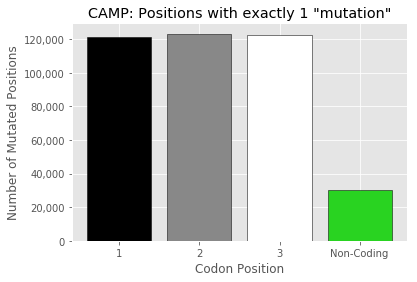

BUT: Positions with exactly 1 "mutation" [112655, 116260, 116243, 32684]


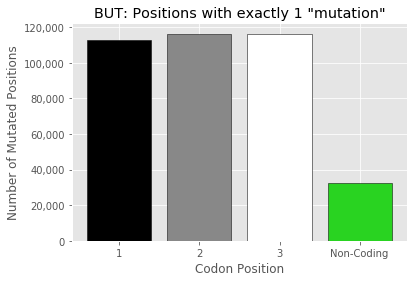

BACT: Positions with exactly 1 "mutation" [215640, 221982, 211794, 144806]


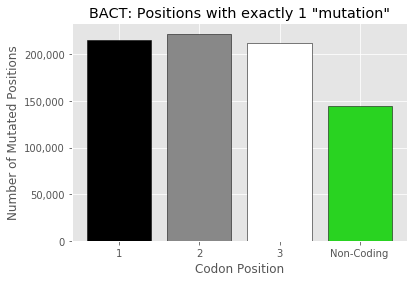

In [8]:
f = lambda cov, mismatches: 1 if mismatches == 1 else 0
histogram_maker(f, 'Positions with exactly 1 "mutation"', normalize=False)

### Exactly 2 "mutations"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with exactly 2 "mutations" [50797, 54554, 54716, 14920]


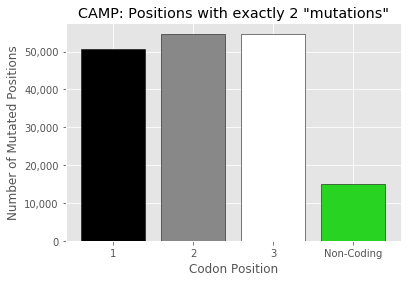

BUT: Positions with exactly 2 "mutations" [34236, 36374, 37286, 11393]


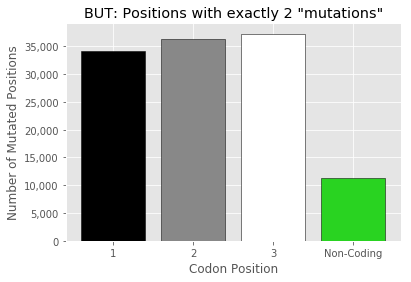

BACT: Positions with exactly 2 "mutations" [72653, 74825, 71006, 54896]


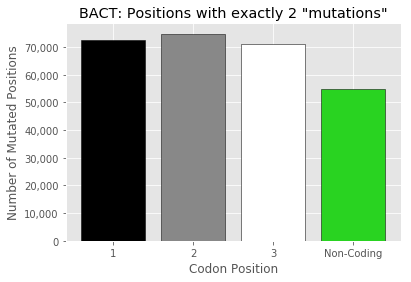

In [9]:
f = lambda cov, mismatches: 1 if mismatches == 2 else 0
histogram_maker(f, 'Positions with exactly 2 "mutations"', normalize=False)

### Exactly 3 "mutations"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with exactly 3 "mutations" [19012, 21061, 21454, 6483]


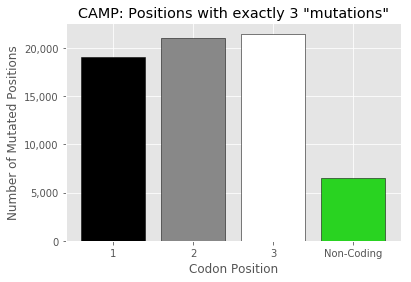

BUT: Positions with exactly 3 "mutations" [9984, 10458, 11238, 3826]


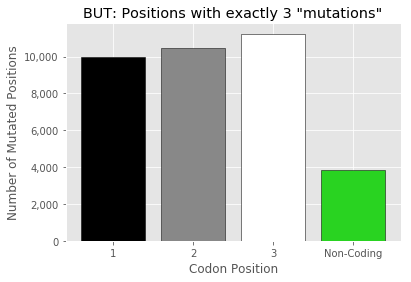

BACT: Positions with exactly 3 "mutations" [22917, 23604, 23174, 20452]


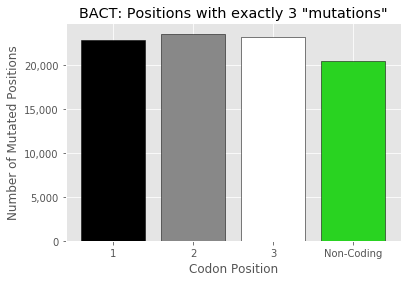

In [10]:
f = lambda cov, mismatches: 1 if mismatches == 3 else 0
histogram_maker(f, 'Positions with exactly 3 "mutations"', normalize=False)

### Exactly 4 "mutations"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with exactly 4 "mutations" [7379, 8255, 8549, 3003]


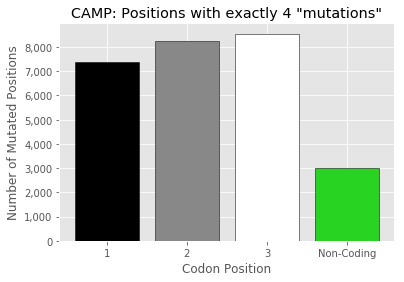

BUT: Positions with exactly 4 "mutations" [3214, 3332, 3529, 1513]


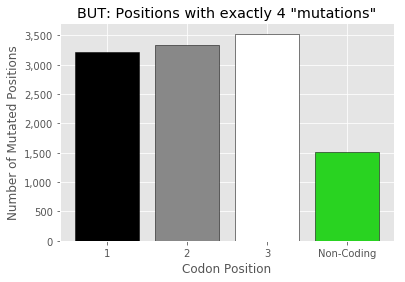

BACT: Positions with exactly 4 "mutations" [7887, 7928, 8591, 8340]


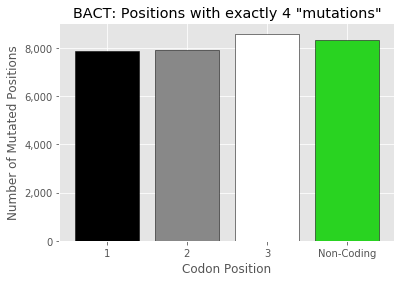

In [11]:
f = lambda cov, mismatches: 1 if mismatches == 4 else 0
histogram_maker(f, 'Positions with exactly 4 "mutations"', normalize=False)

### At least 1 mutation (just 1/2/3, to test that ignoring non-coding positions works)

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with at least 1 mutation [205531, 214359, 215962]


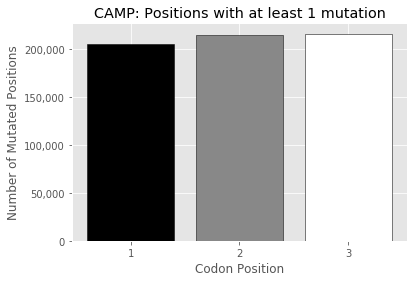

BUT: Positions with at least 1 mutation [163074, 169218, 172004]


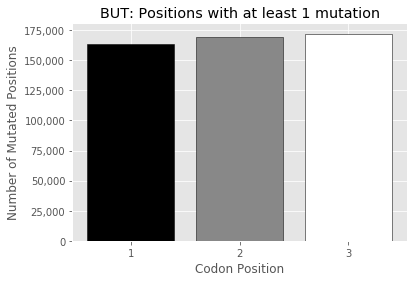

BACT: Positions with at least 1 mutation [329448, 337196, 331999]


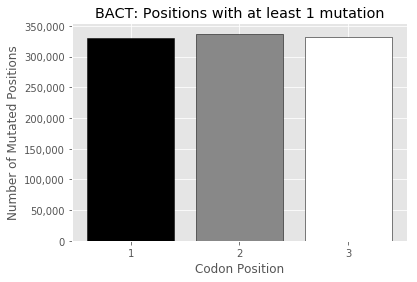

In [12]:
f = lambda cov, mismatches: 1 if mismatches >= 1 else 0
histogram_maker(f, 'Positions with at least 1 mutation', normalize=False, add_noncoding_col=False)

### At least {1, 2, 3, 4} "mutation(s)"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with at least 1 "mutation" [205531, 214359, 215962, 58715]


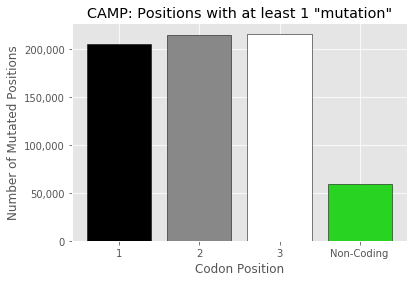

BUT: Positions with at least 1 "mutation" [163074, 169218, 172004, 53144]


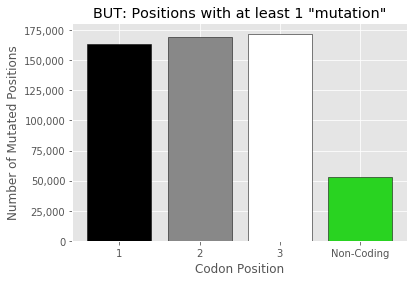

BACT: Positions with at least 1 "mutation" [329448, 337196, 331999, 247257]


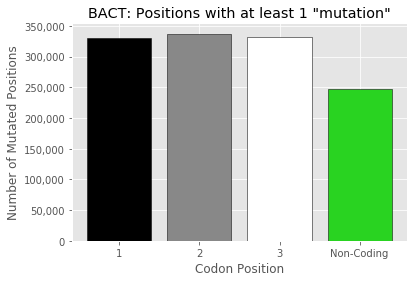

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with at least 2 "mutations" [84475, 91096, 93256, 28260]


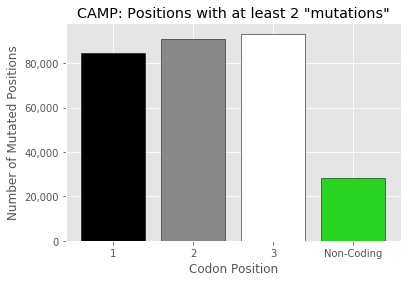

BUT: Positions with at least 2 "mutations" [50419, 52958, 55761, 20460]


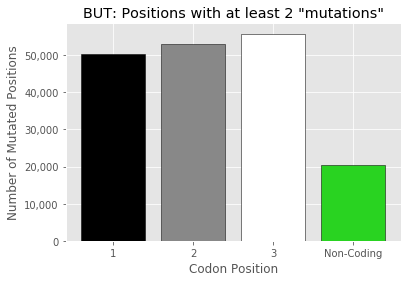

BACT: Positions with at least 2 "mutations" [113808, 115214, 120205, 102451]


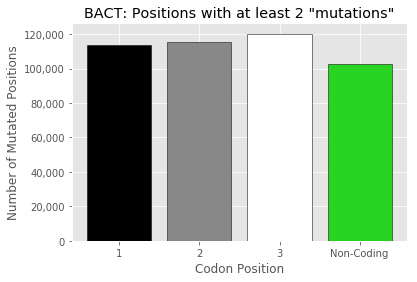

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with at least 3 "mutations" [33678, 36542, 38540, 13340]


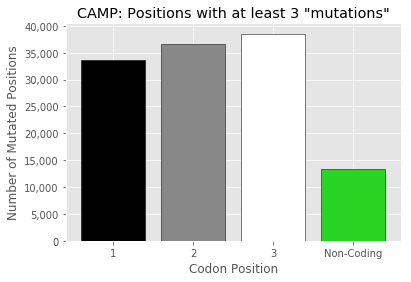

BUT: Positions with at least 3 "mutations" [16183, 16584, 18475, 9067]


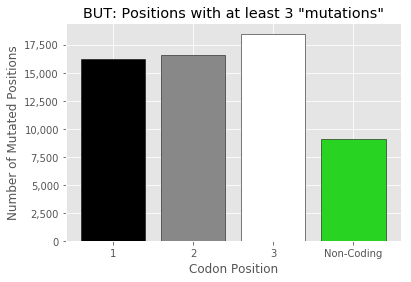

BACT: Positions with at least 3 "mutations" [41155, 40389, 49199, 47555]


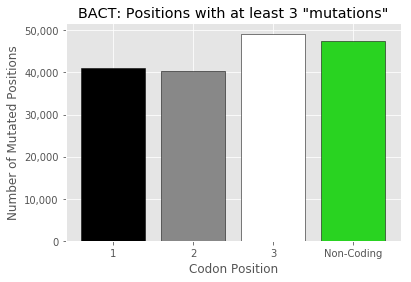

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with at least 4 "mutations" [14666, 15481, 17086, 6857]


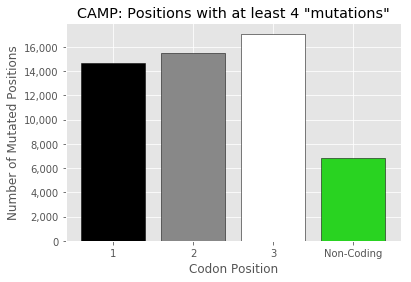

BUT: Positions with at least 4 "mutations" [6199, 6126, 7237, 5241]


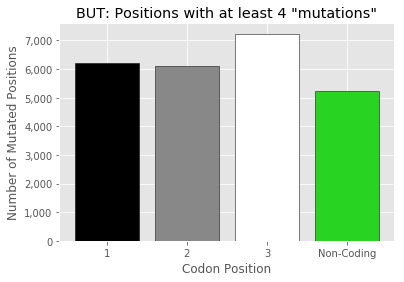

BACT: Positions with at least 4 "mutations" [18238, 16785, 26025, 27103]


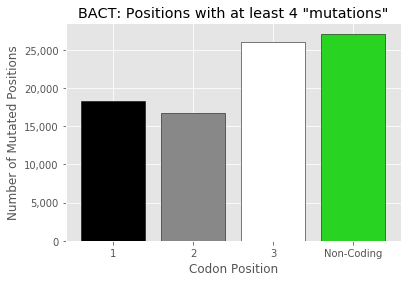

In [13]:
at_least_n_mutations = [1, 2, 3, 4]
for n in at_least_n_mutations:
    if n == 1:
        noun = "mutation"
    else:
        noun = "mutations"
    f = lambda cov, mismatches: 1 if mismatches >= n else 0
    histogram_maker(f, 'Positions with at least {} "{}"'.format(n, noun), normalize=False)

### 10 or more "mutations"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 10 or more "mutations" [1001, 886, 1248, 609]


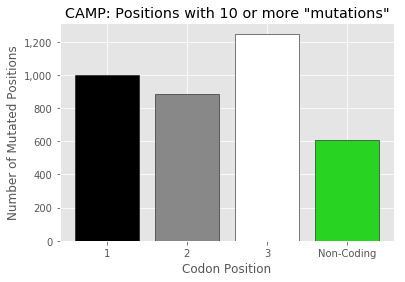

BUT: Positions with 10 or more "mutations" [573, 433, 1174, 2190]


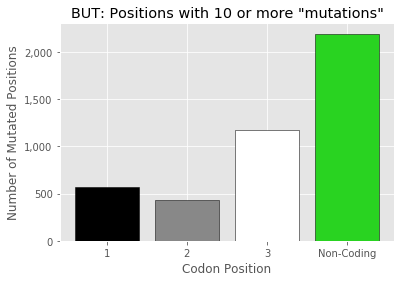

BACT: Positions with 10 or more "mutations" [3303, 2478, 8984, 9903]


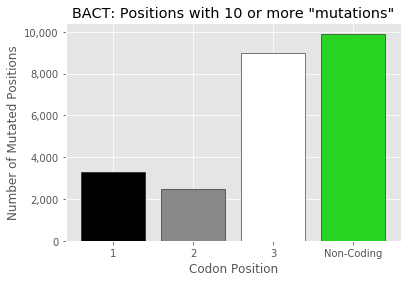

In [14]:
f = lambda cov, mismatches: 1 if mismatches >= 10 else 0
histogram_maker(f, 'Positions with 10 or more "mutations"', normalize=False)

### 2%, 1%, 0.5%, 0.25%, 0.1%, 0.05% or more mutations

Without normalization (so the y-axis is just # of mutated positions)

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 2% or more "mutations" [197, 145, 355, 37]


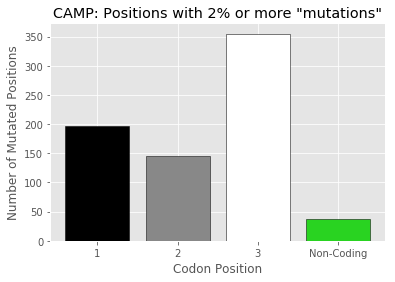

BUT: Positions with 2% or more "mutations" [303, 191, 876, 1450]


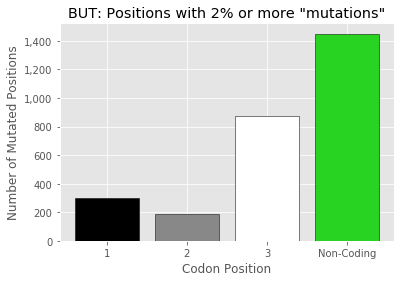

BACT: Positions with 2% or more "mutations" [865, 666, 2656, 5658]


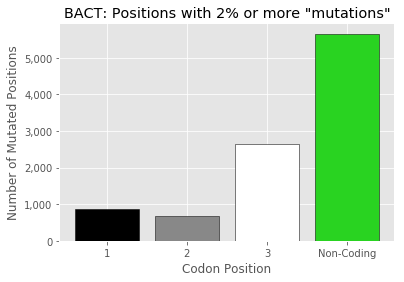

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 1% or more "mutations" [244, 183, 389, 58]


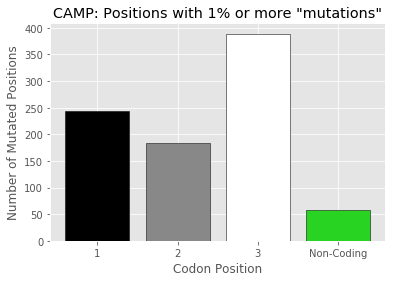

BUT: Positions with 1% or more "mutations" [377, 266, 1037, 1731]


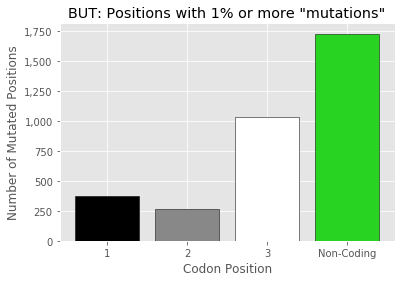

BACT: Positions with 1% or more "mutations" [1286, 944, 4285, 6767]


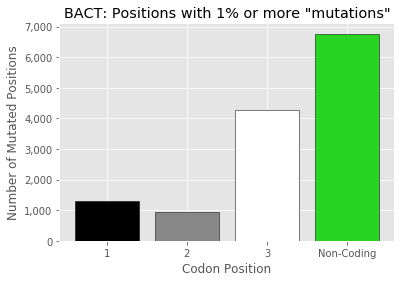

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.5% or more "mutations" [316, 254, 492, 120]


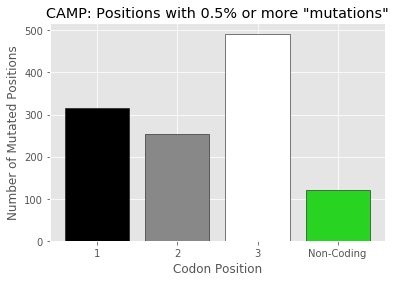

BUT: Positions with 0.5% or more "mutations" [884, 787, 1641, 2377]


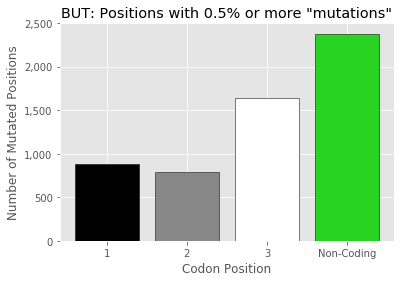

BACT: Positions with 0.5% or more "mutations" [2052, 1482, 6313, 8057]


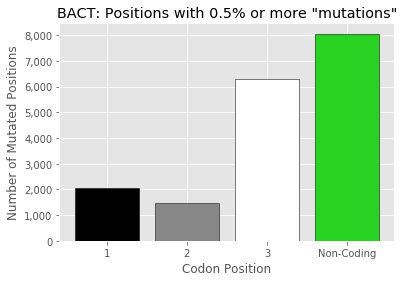

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.25% or more "mutations" [846, 773, 1107, 520]


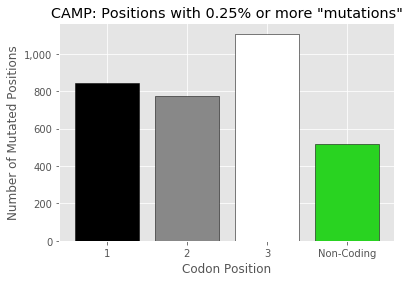

BUT: Positions with 0.25% or more "mutations" [5114, 5263, 5979, 4697]


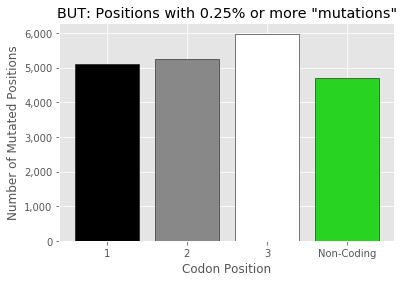

BACT: Positions with 0.25% or more "mutations" [4178, 3277, 10076, 10859]


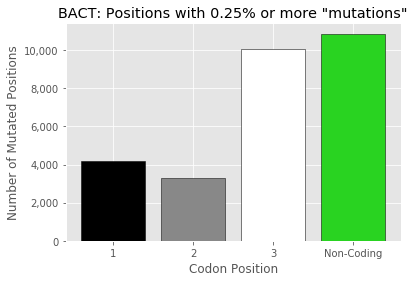

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.1% or more "mutations" [9999, 10202, 11729, 5084]


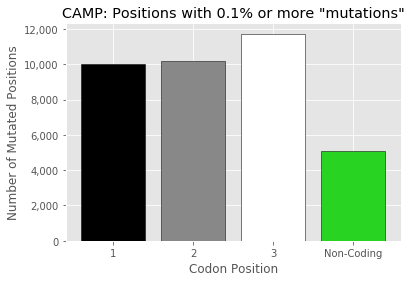

BUT: Positions with 0.1% or more "mutations" [20134, 20932, 22727, 10976]


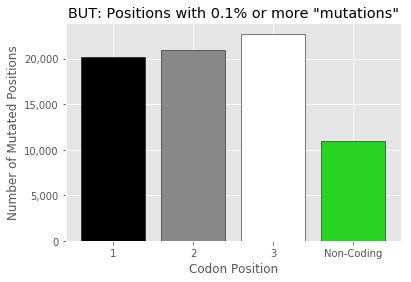

BACT: Positions with 0.1% or more "mutations" [29563, 28154, 37559, 36501]


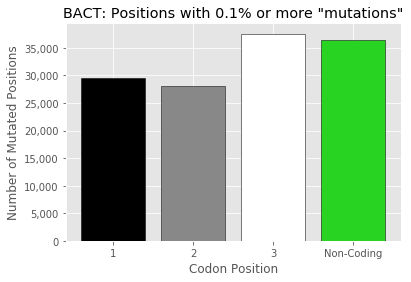

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.05% or more "mutations" [52988, 57157, 59225, 19749]


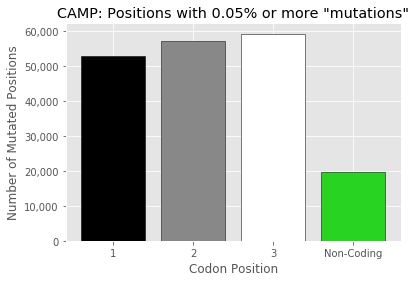

BUT: Positions with 0.05% or more "mutations" [54975, 57854, 60527, 22697]


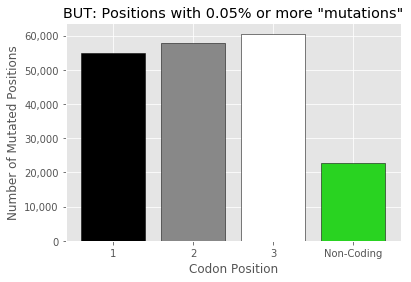

BACT: Positions with 0.05% or more "mutations" [112024, 113347, 118822, 99846]


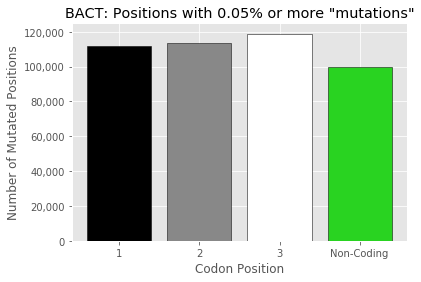

In [15]:
percentages = [2, 1, 0.5, 0.25, 0.1, 0.05]
for pct in percentages:
    threshold = pct / 100
    f = lambda cov, mismatches: 1 if (mismatches / cov) >= threshold else 0
    histogram_maker(f, 'Positions with {}% or more "mutations"'.format(pct), normalize=False)

With normalization, and making y-axes comparable for each row

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 2% or more "mutations" [0.0004955812765871808, 0.0003647679446961483, 0.0008930525542560872, 0.0003670416443465667]


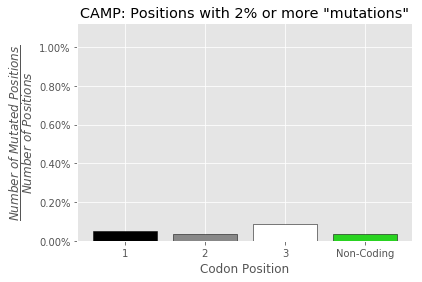

BUT: Positions with 2% or more "mutations" [0.0006123240831305725, 0.0003859864682440243, 0.0017702834878626453, 0.009373525285892522]


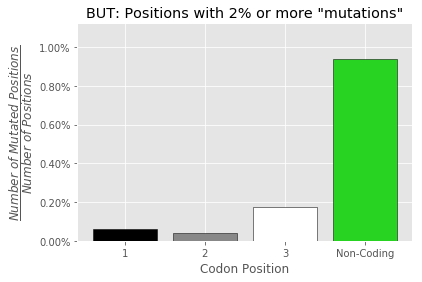

BACT: Positions with 2% or more "mutations" [0.0011268713881492213, 0.0008676258318004408, 0.0034600813952882447, 0.01101223841554559]


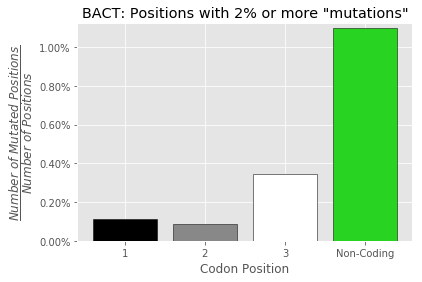

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 1% or more "mutations" [0.0006138164034886909, 0.0004603623026165182, 0.0009785843481848393, 0.0005753625776243477]


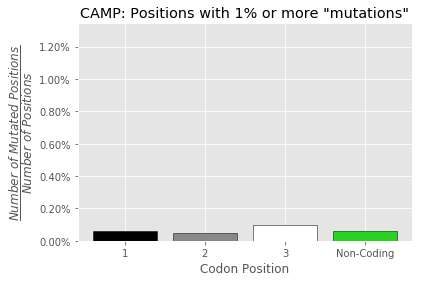

BUT: Positions with 1% or more "mutations" [0.0007618685786806134, 0.0005375518353555521, 0.0020956438092620587, 0.01119004984129652]


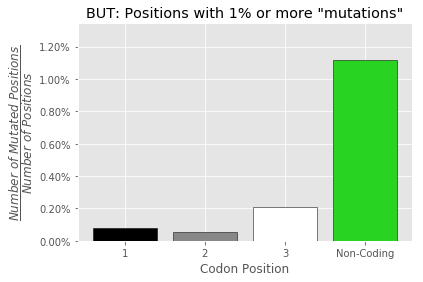

BACT: Positions with 1% or more "mutations" [0.0016753255550981485, 0.0012297879657952194, 0.005582247281178512, 0.01317069942700548]


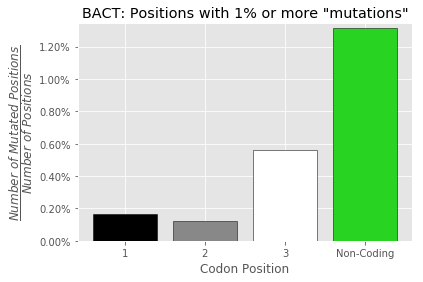

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.5% or more "mutations" [0.0007949425553378128, 0.0006389728134677357, 0.0012376953709689997, 0.0011904053330158918]


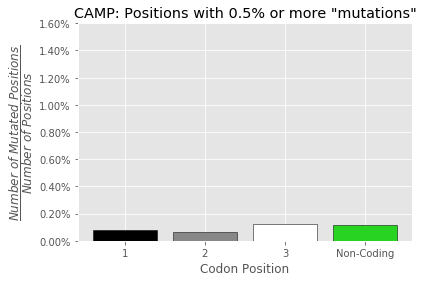

BUT: Positions with 0.5% or more "mutations" [0.0017864504603545418, 0.001590425918890299, 0.0033162502324002295, 0.015366116968666568]


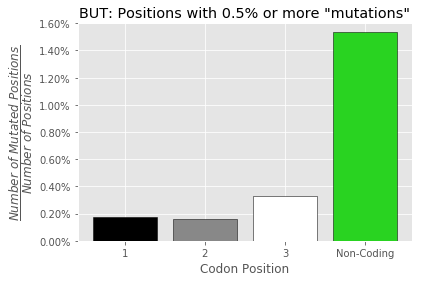

BACT: Positions with 0.5% or more "mutations" [0.0026732255358175743, 0.0019306628869793594, 0.00822420702125553, 0.01568144307424016]


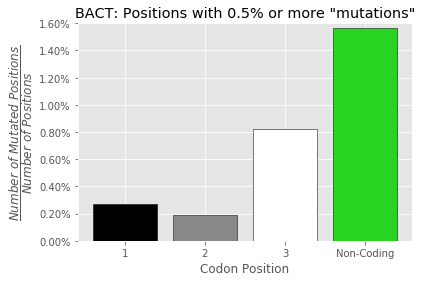

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.25% or more "mutations" [0.0021282322842271825, 0.0019445904913801561, 0.0027848145846802496, 0.005158423109735532]


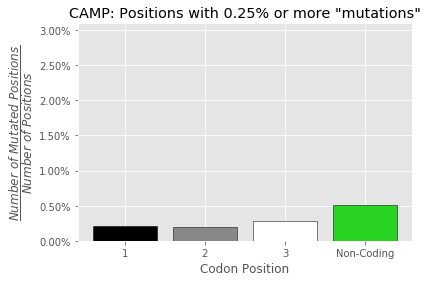

BUT: Positions with 0.25% or more "mutations" [0.010334737165444714, 0.010635847028106282, 0.012082791066131, 0.030363757426094602]


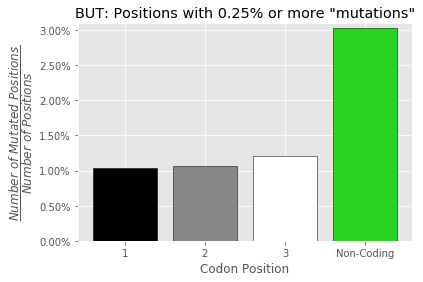

BACT: Positions with 0.25% or more "mutations" [0.005442853941835198, 0.004269083860075142, 0.01312642324507694, 0.021135011833582462]


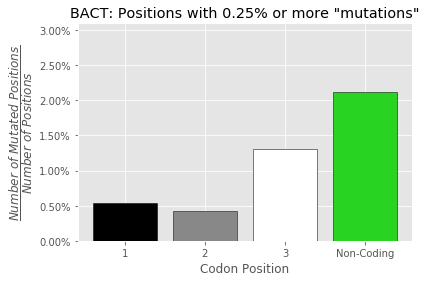

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.1% or more "mutations" [0.025153894338046805, 0.025664569460621414, 0.02950595326442154, 0.05043350594210662]


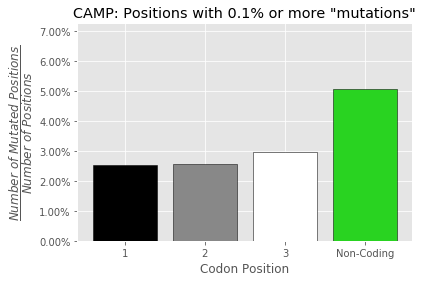

BUT: Positions with 0.1% or more "mutations" [0.040688228018980026, 0.042300883525046684, 0.045928347977915916, 0.07095435416410781]


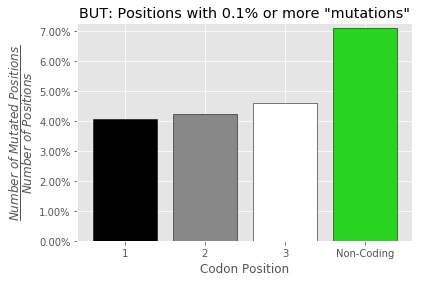

BACT: Positions with 0.1% or more "mutations" [0.03851294664491957, 0.036677383886651066, 0.048929667592481615, 0.0710423673393124]


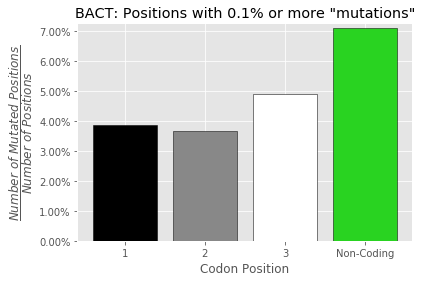

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 0.05% or more "mutations" [0.13329878519696212, 0.14378649251722586, 0.1489888381008923, 0.1959109576810904]


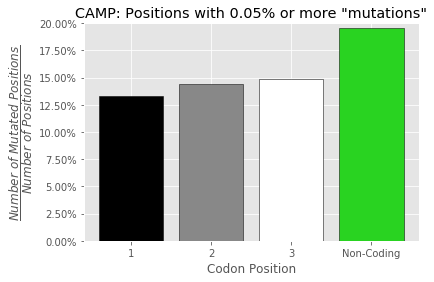

BUT: Positions with 0.05% or more "mutations" [0.11109741409274992, 0.11691550331827111, 0.12231729300212596, 0.1467247609751052]


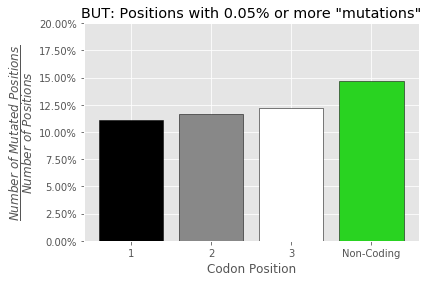

BACT: Positions with 0.05% or more "mutations" [0.1459383125850039, 0.14766183957520204, 0.15479434922851648, 0.19433155829596413]


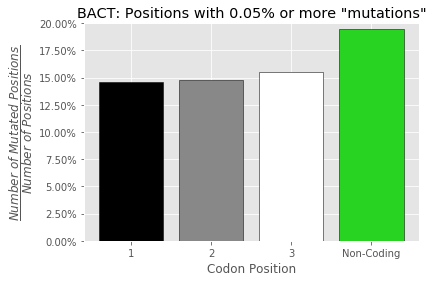

In [16]:
for pct in percentages:
    threshold = pct / 100
    f = lambda cov, mismatches: 1 if (mismatches / cov) >= threshold else 0
    histogram_maker(f, 'Positions with {}% or more "mutations"'.format(pct),
                    normalize=True, make_yaxes_comparable=True)

### 50% or more "mutations"

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)
CAMP: Positions with 50% or more "mutations" [0, 0, 2, 2]


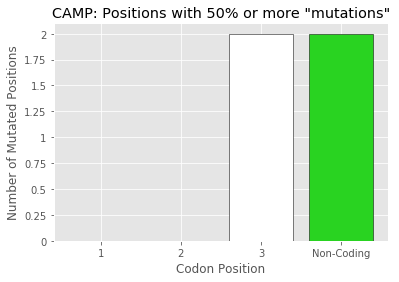

BUT: Positions with 50% or more "mutations" [4, 4, 14, 68]


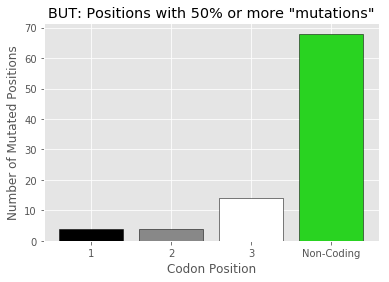

BACT: Positions with 50% or more "mutations" [42, 32, 117, 326]


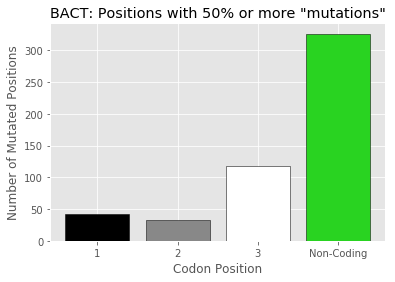

In [17]:
f = lambda cov, mismatches: 1 if (mismatches / cov) >= 0.5 else 0
histogram_maker(f, 'Positions with 50% or more "mutations"')

## Generate scatterplots of CP 1/2/3 mutated position proportions in genes

The goal is showing "outlier" genes with particularly high mutation rates.

In [18]:
from parse_sco import parse_sco

def gene_scatterplot_maker(pseudo_variant_caller, output_dict=False, seq2genes_to_highlight={}):
    """Shows scatterplots of mutated position proportions in the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    pseudo_variant_caller: function
        Works similarly to histogram_maker().
        Takes as input two parameters:
            1. cov: an integer describing number of reads aligned to a position (just matches & mismatches)
            2. mismatchct: an integer describing the number of matching reads aligned to a position
            
        Should return a number: 1 if a position is "mutated", 0 if not mutated. Yeah, ideally this would
        return a bool, but numbers make this easier.
        
        We guarantee that cov will be > 0 when this is called -- for positions where cov <= 0, this'll just
        automatically call this position as not mutated.
        
    seq2genes_to_highlight: dict
        Maps sequence names to a dict mapping gene numbers (as ints) to hex colors.
        Selected genes will be enlarged in scatterplots and colored accordingly, so that they can be visually
        emphasized.
    """
    max_cp1_nm = 0
    max_cp2_nm = 0
    max_cp3_nm = 0
    seq2gene2normalizedmutct = {}
    for seq in SEQS:
        df = parse_sco(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
        )
        # Go through each gene in this sequence, and compute the (normalized) mutated-position frequency at
        # each of its three codon positions.
        seq2gene2normalizedmutct[seq] = {}
        for gene in df.itertuples():
            i = 1
            cp1_mutct = 0
            cp2_mutct = 0
            cp3_mutct = 0
            for pos in get_pos_interval_from_gene(gene):
                matchct = seq2pos2matchct[seq][str(pos)]
                mismatchct = seq2pos2mismatchct[seq][str(pos)]
                cov = mismatchct + matchct
                if cov > 0:
                    val = pseudo_variant_caller(cov, mismatchct)
                else:
                    print(
                        "Found position with 0 mismatches or matches in {}: pos={} (assigning value of 0)".format(
                            seq, pos
                        )
                    )
                    val = 0
                if val not in [0, 1]:
                    raise ValueError("Output of pseudo_variant_caller should just be an 0 or 1.")
                if i == 1:
                    cp1_mutct += val
                    i = 2
                elif i == 2:
                    cp2_mutct += val
                    i = 3
                elif i == 3:
                    cp3_mutct += val
                    i = 1
                else:
                    raise ValueError("Codon position modulo calculation is broken :|")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")

            onethirdlen = gene.Length / 3
            nm1 = cp1_mutct / onethirdlen
            nm2 = cp2_mutct / onethirdlen
            nm3 = cp3_mutct / onethirdlen
            seq2gene2normalizedmutct[seq][gene.Index] = [nm1, nm2, nm3]
            # Try to update maxima
            max_cp1_nm = max(max_cp1_nm, nm1)
            max_cp2_nm = max(max_cp2_nm, nm2)
            max_cp3_nm = max(max_cp3_nm, nm3)

    # Only do plotting after we've seen all genes in all sequences. This ensures that we know the maximum
    # fraction of (mutated positions / one third gene length) across all CPs in all genes in all sequences.
    # (I mean, the theoretical maximum of this is just 1, in the case where all positions in a CP in a gene
    # are mutated... but that PROBABLY won't happen unless there are some really tiny and/or wacky genes)
    max_cp_nm = max(max_cp1_nm, max_cp2_nm, max_cp3_nm)
    
    
    # Compute scatterplots for CP 1 vs. CP 2 mutated-position frequencies for all genes
    # within this sequence
    def show_cp_vs_cp_plot(seq, x_cp, y_cp):
        """x_cp and y_cp should be 1-indexed CP numbers (one of [1, 2, 3])."""
        if x_cp not in [1,2,3] or y_cp not in [1,2,3]:
            raise ValueError("CPs must be one of [1, 2, 3].")
            
        gene_normalizedmutcts = seq2gene2normalizedmutct[seq].values()
        
        pyplot.title('{}: "Mutated position" frequencies in predicted genes'.format(seq2name[seq]))
        axis_label = "Normalized number of mutated positions in CP {}"
        pyplot.xlabel(axis_label.format(x_cp))
        pyplot.ylabel(axis_label.format(y_cp))
        
        # This is the default size of scatterplot points in matplotlib: see the "s" param docs
        # at https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html.
        dflt_size = (matplotlib.rcParams["lines.markersize"] ** 2)
        
        for gene in seq2gene2normalizedmutct[seq].keys():
            if seq in seq2genes_to_highlight and gene in seq2genes_to_highlight[seq]:
                color = seq2genes_to_highlight[seq][gene]
                # Double "size" of highlighted genes. There is a bit of ambiguity as to what exactly
                # "size" means (area?) -- see https://stackoverflow.com/a/47403507. Rather than spending 30
                # minutes doing a deep dive into this I'm just gonna multiply by four and call it a day
                size = 4 * dflt_size
            else:
                color = SCATTERPLOT_PT_COLOR
                size = dflt_size
            pyplot.scatter(
                seq2gene2normalizedmutct[seq][gene][x_cp - 1],
                seq2gene2normalizedmutct[seq][gene][y_cp - 1],
                c=color,
                s=size
            )
        
        pyplot.xlim(0, max_cp_nm)
        pyplot.ylim(0, max_cp_nm)
        
        # Plot diagonal line: https://stackoverflow.com/a/22105008
        # Get "ax": https://stackoverflow.com/a/15067854
        pyplot.plot(pyplot.gca().get_xlim(), pyplot.gca().get_ylim(), ls="--", c=".3")
        
        # Make figure square
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(6, 6)
        
        pyplot.show()
        
    for seq in SEQS:
        show_cp_vs_cp_plot(seq, 1, 2)        
        show_cp_vs_cp_plot(seq, 1, 3)
        
    if output_dict:
        return seq2gene2normalizedmutct

Found position with 0 mismatches or matches in edge_1371: pos=66 (assigning value of 0)


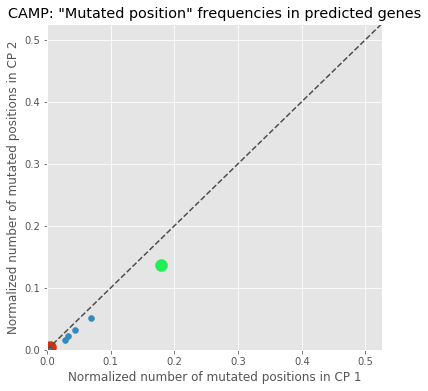

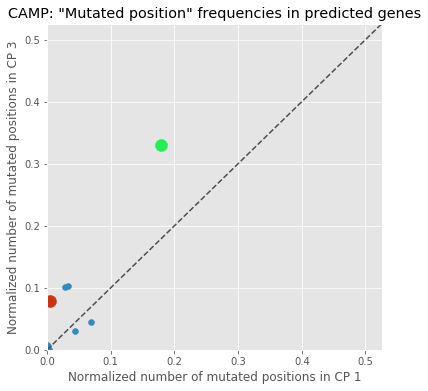

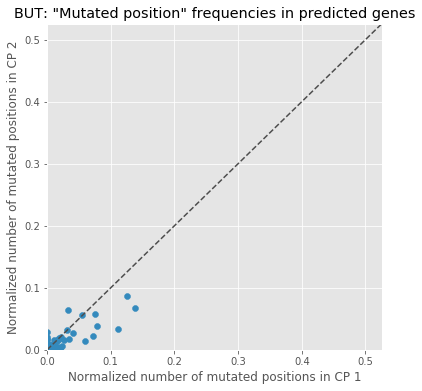

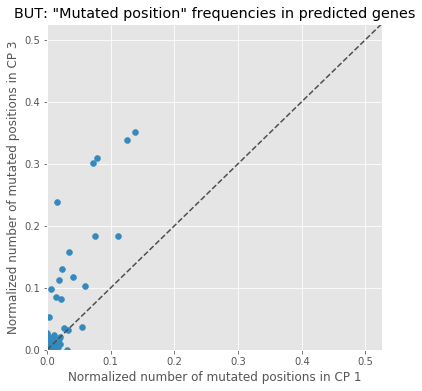

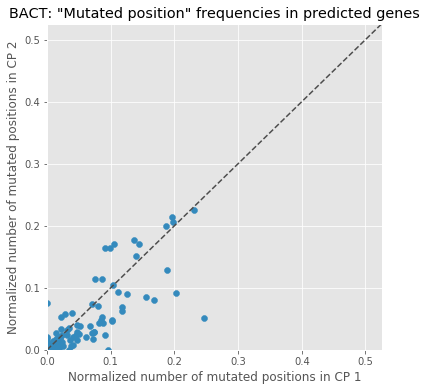

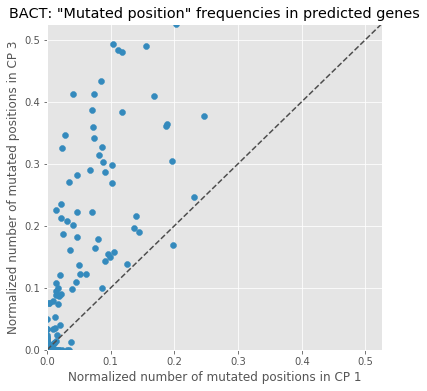

In [19]:
seq2gene2normalizedmutct = gene_scatterplot_maker(
    lambda cov, mismatches: 1 if (mismatches / cov) >= 0.01 else 0,
    True,
    {"edge_6104": {1217: "#cc3311", 206: "#22ee55"}},
)

In [20]:
# Focus on specific outlier genes in CAMP, manually... (ideally this would be paired with interactive plots
# using Altair or something but installing that is hard)
seq = "edge_6104"
for gene in seq2gene2normalizedmutct[seq]:
    if seq2gene2normalizedmutct[seq][gene][2] > 0.05:
        print(gene, seq2gene2normalizedmutct[seq][gene])

89 [0.02857142857142857, 0.015238095238095238, 0.10095238095238095]
206 [0.17953667953667954, 0.13706563706563707, 0.3301158301158301]
970 [0.03225806451612903, 0.022770398481973434, 0.10246679316888045]
1217 [0.005221932114882507, 0.005221932114882507, 0.0783289817232376]


## Compute mutation profiles
Number of positions with one mutation, number of positions with two mutations, etc.

**IMPORTANT NOTE**: We omit 0 values from mutation profile plots (i.e. numbers of mutations where 0 positions have exactly that many mutations). This both unclutters the plots AND lets us use normal log scales without problems. Plotting 0 values in a log scale is doable using pyplot's symlog option, but this isn't necessary for these plots at least.

(it's not really an "important note", but I spent like an hour trying to understand this when recreating these plots elsewhere...)

In [88]:
from collections import defaultdict
import os

def get_mutation_profile(seq):
    num_mutations_to_freq = defaultdict(int)
    for pos in seq2pos2matchct[seq]:
        mismatch_and_match_ct = seq2pos2matchct[seq][pos] + seq2pos2mismatchct[seq][pos]
        # ignore uncovered places. Could also ignore places with less than some threshold coverage (e.g. 5).
        if mismatch_and_match_ct == 0:
            continue
        num_mutations_to_freq[seq2pos2mismatchct[seq][pos]] += 1
    return num_mutations_to_freq

def view_mutation_profiles(xlim_max=None, ylim_max=None, logscale=False):
    for seq in SEQS:
        num_mutations_to_freq = get_mutation_profile(seq)
        
        # .keys() and .values() should be in the same order: https://stackoverflow.com/a/835430
        pyplot.scatter(num_mutations_to_freq.keys(), num_mutations_to_freq.values(), c=SCATTERPLOT_PT_COLOR)
        
        ylabel = "How many positions have\nthis many mutations?"
        if logscale:
            # https://stackoverflow.com/a/14530857
            pyplot.gca().set_yscale("log")
            ylabel += " (log$_{10}$ scale)"
        pyplot.xlabel("Number of mutations")
        pyplot.ylabel(ylabel)
        
        title = "{}: Mutation Profile".format(seq2name[seq])
        
        if ylim_max is None:
            pyplot.ylim(0)
        else:
            pyplot.ylim(0, ylim_max)
            title += "\n(y-axis truncated to {})".format(ylim_max)
        if xlim_max is None:
            pyplot.xlim(0)
        else:
            pyplot.xlim(0, xlim_max)
            title += "\n(x-axis truncated to {})".format(xlim_max)
        pyplot.title(title)
        use_thousands_sep(pyplot.gca().xaxis)
        pyplot.show()

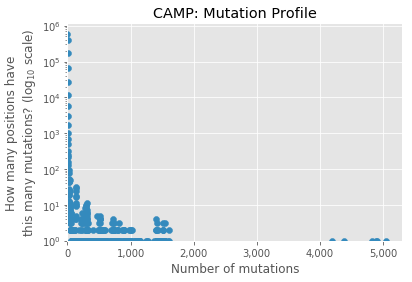

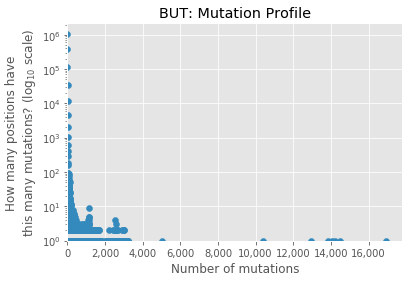

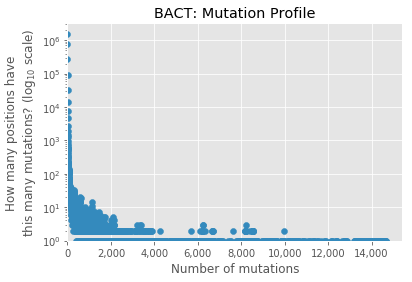

In [89]:
view_mutation_profiles(logscale=True)

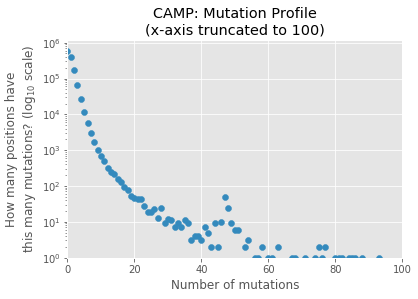

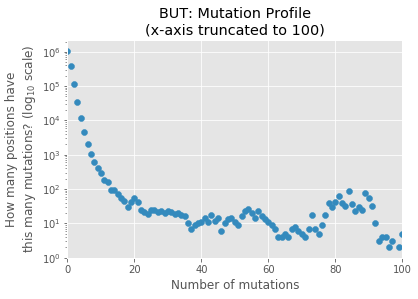

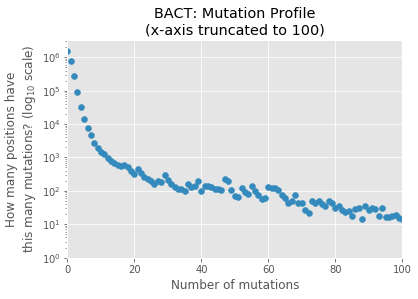

In [90]:
view_mutation_profiles(xlim_max=100, logscale=True)

## Plot along-gene mutation rates

Of genes we're interested in in CAMP. But we could of course generalize this / show multiple genes at once.

In [24]:
def plot_gene_mutation_spectrum(seq, leftend, rightend, cutoff=None):
    """leftend must be < rightend -- so if this is a reverse gene,
    the end position should still be leftend, I think.
    
    "cutoff" can optionally be a float. If cutoff is not None, then this'll print out
    information about the number of positions where the percentage of mismatches is >= cutoff.
    (Mostly useful for adding to figure captions...)
    """
    one_cycle_through = False
    gene_positions = range(leftend, rightend + 1)
    cp = 1
    num_called_mutations = 0
    # We adopt the strategy here of calling pyplot.scatter() for each data point to plot, rather than
    # building up lists of x-axis, y-axis, and color values and plotting that. See e.g.
    # https://stackoverflow.com/questions/42180475#comment71523984_42180475 for documentation on this.
    for p in gene_positions:
        sp = str(p)
        cov = seq2pos2mismatchct[seq][sp] + seq2pos2matchct[seq][sp]
        pct = seq2pos2mismatchct[seq][sp] / cov
        # If we assign a label to every datapoint, then the duplicate labels show up in the legend.
        # To avoid this, we just only assign labels to the first three points at a codon position:
        # https://stackoverflow.com/a/19386045.
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        pyplot.scatter(p, pct, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1
        if cutoff is not None and pct >= cutoff:
            num_called_mutations += 1
    
    if cutoff is not None:
        print("{} / {} positions have a mismatch rate >= the cutoff of {}".format(
            num_called_mutations, len(gene_positions), cutoff
        ))

    pyplot.title("Mutation spectrum of a gene (left end: {:,}, right end: {:,}) in CAMP".format(leftend, rightend))
    pyplot.xlabel("Sequence position")
    # https://stackoverflow.com/a/27474400
    pyplot.ylabel("$\dfrac{Mismatches}{Mismatches + Matches}$")
    pyplot.ylim(0)
    pyplot.legend()
    
    # Disable "offset" on the x-axis. This prevents matplotlib from replacing literal sequence positions with
    # smaller numbers and then adding a "+1.21e6" off to the side of the axis (which is... a lot more confusing
    # for this particular application than just listing the actual sequence positions). Doing this *after* the
    # percentage thing below doesn't seem to work, but doing it up here works. I dunno, matplotlib is hard.
    # See https://stackoverflow.com/a/28373421.
    pyplot.ticklabel_format(useOffset=False)
    
    # Make the y-axis show percentages: based on
    # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
    pyplot.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    
    # Use thousands separator on the x-axis
    use_thousands_sep(pyplot.gca().xaxis)
    
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)

In [25]:
def plot_gene_coverage(seq, leftend, rightend):
    gene_positions = range(leftend, rightend + 1)
    one_cycle_through = False
    cp = 1
    for p in gene_positions:
        cov = seq2pos2totalcov[seq][str(p)]
        label = "" if one_cycle_through else "Codon Position {}".format(cp)
        pyplot.scatter(p, cov, c=cp2color[cp], label=label, edgecolor=BORDERCOLOR)
        if cp == 3:
            cp = 1
            one_cycle_through = True
        else:
            cp += 1

    pyplot.title("Coverage across a gene (left end: {:,}, right end: {:,}) in CAMP".format(leftend, rightend))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of reads aligned to this position")
    pyplot.legend()
    pyplot.ticklabel_format(useOffset=False)
    use_thousands_sep(pyplot.gca().xaxis)
    use_thousands_sep(pyplot.gca().yaxis)
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)

### Along-gene mutation rates for gene 1217 in CAMP (which exhibits "binarized" mutation rates)
The reason we go with this gene is it stood out really clearly in an earlier version of this analysis, where we were using the scaffold for CAMP rather than a single edge. It's still an outlier in the plot, just not the you know hugest one. That's understandable -- we've changed a lot about the way we process the data throughout the span of this project.

34 / 1149 positions have a mismatch rate >= the cutoff of 0.14


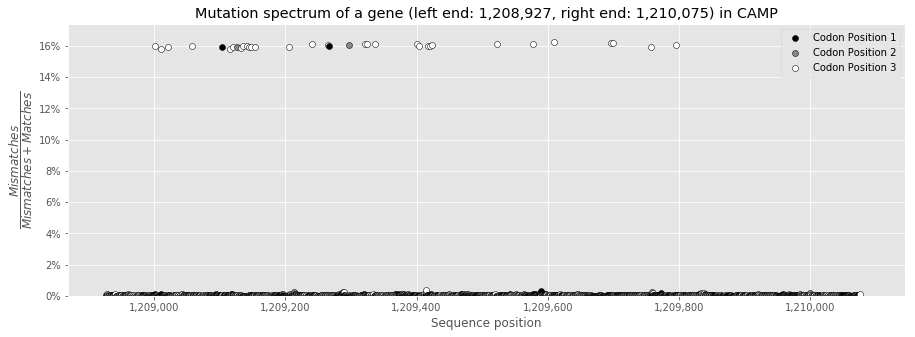

In [26]:
# We pass cutoff=0.14 so the function will count the number of positions above a 14% mutation rate
# The "center" is obvs closer to 16%, but to be careful and make sure we count everything we set it to 14%
plot_gene_mutation_spectrum("edge_6104", 1208927, 1210075, cutoff=0.14)

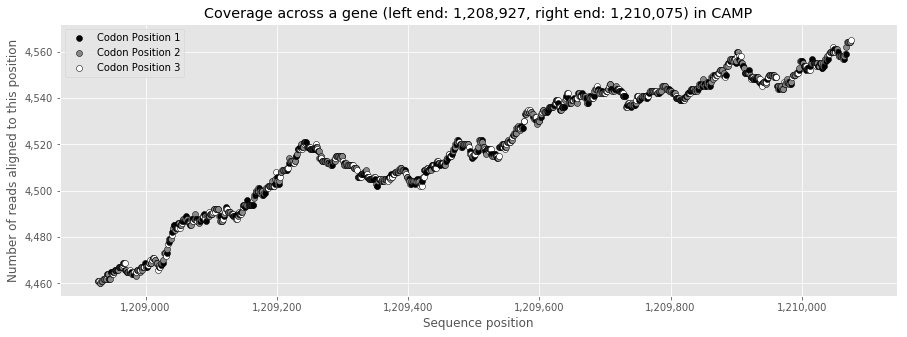

In [27]:
plot_gene_coverage("edge_6104", 1208927, 1210075)

### Along-gene mutation rates for gene 206 in CAMP (less clearly defined pattern)

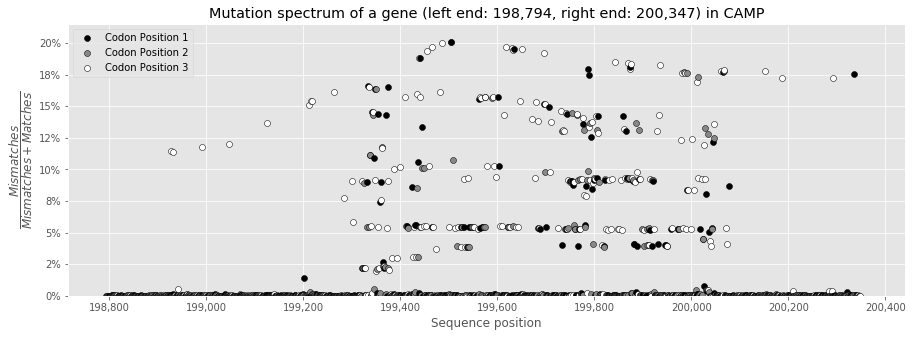

In [28]:
# The gene we're going to plot here is number 206.
plot_gene_mutation_spectrum("edge_6104", 198794, 200347)

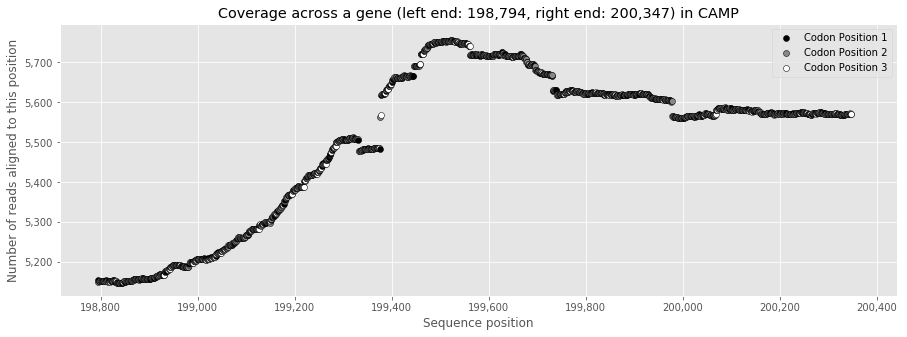

In [29]:
plot_gene_coverage("edge_6104", 198794, 200347)

### Plot coverages across genomes

In [30]:
def show_coverage_plot(seq):
    # seq2pos2cov stores positions as strings, but we need to plot them as ints
    int_positions = sorted([int(p) for p in seq2pos2totalcov[seq].keys()])
    str_positions = [str(p) for p in int_positions]
    coverages = [seq2pos2totalcov[seq][pos] for pos in str_positions]
    pyplot.scatter(int_positions, coverages, c=SCATTERPLOT_PT_COLOR)
    pyplot.title("{}: Coverage across genome".format(seq2name[seq]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of reads aligned to this position")
    
    # Limit the number of ticks on the x-axis, to avoid overlapping position labels.
    # https://stackoverflow.com/a/13418954
    pyplot.locator_params(axis="x", nbins=10)
    
    use_thousands_sep(pyplot.gca().xaxis)
    use_thousands_sep(pyplot.gca().yaxis)
    
    pyplot.ylim(0)
    
    # Make figure wide: https://stackoverflow.com/a/4306340
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 5)
    pyplot.show()

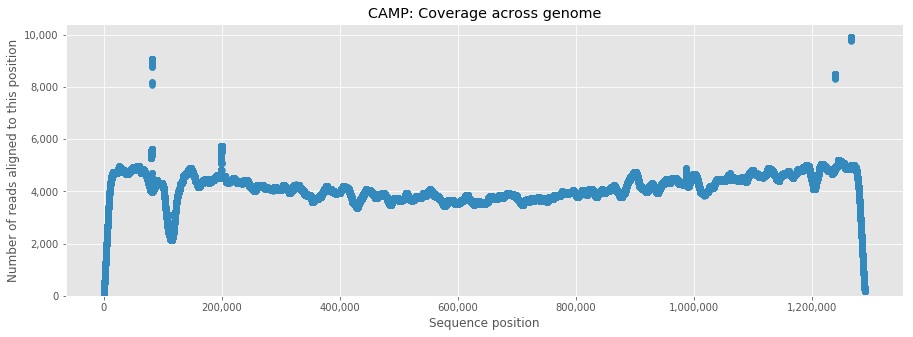

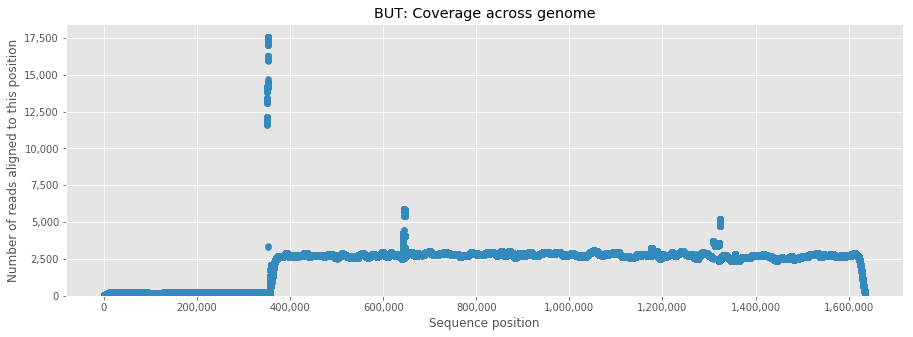

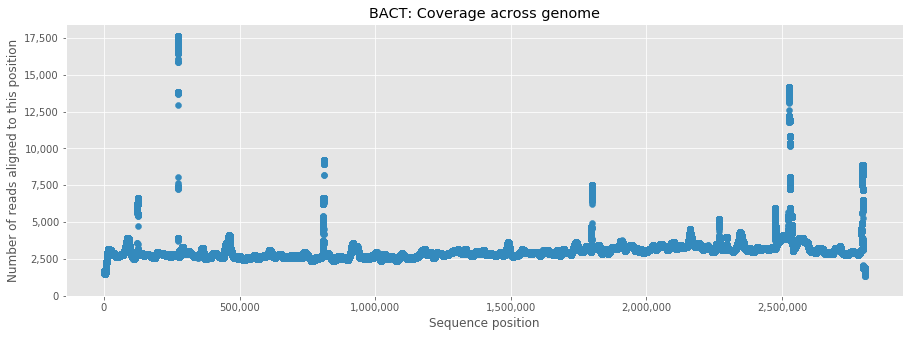

In [31]:
show_coverage_plot("edge_6104")
show_coverage_plot("edge_1371")
show_coverage_plot("edge_2358")

## Compute $N_1$, $N_2$, $N_3$ for each position in the genome

NOTE: in the paper we use different numbers (N2 instead of N1, etc), but the idea is the same

(We make the simplifying assumption in the following text that all reads contain only nucleotides, and don't contain degenerate bases like $Y$ or $N$.)

For a genomic position $P$ with a reference nucleotide $R \in \{A, C, G, T\}$, we consider three values: $N_1$, $N_2$, and $N_3$. __Ignoring reads aligned to $P$ that match $R$__, a read aligned to $P$ can have one of three other nucleotides at this position (for example, if $R$ is $A$, then these "non-matching" reads should only describe $C$, $G$, or $T$).

$N_1$, $N_2$, and $N_3$ define the number of non-matching reads aligned to $P$ for each of these three remaining nucleoides, such that $N_1 \geq N_2 \geq N_3$:

- $N_1$ is the number of non-matching reads that contain the most common "alternate" nucleotide at $P$.
- $N_2$ is the number of non-matching reads for the second-most common "alternate" nucleotide at $P$.
- $N_3$ is the number of non-matching reads for the third-most (least) common "alternate" nucleotide at $P$.

For example, if a given position in a reference sequence is $G$ and the covering reads for this position are:

- 100 $G$
- 1 $T$
- 50 $C$
- 5 $A$

Then we would say that $N_1$ = 50 (for $C$), $N_2$ = 5 (for $A$), and $N_3$ = 1 (for $T$).

We note that, for low-coverage and/or stable genomic positions, some or all of $N_1$, $N_2$, and $N_3$ may be zero.

We are interested in computing $f = \dfrac{N_1}{N_1 + N_2 + N_3}$ (which is only defined when $N_1 > 0$).

For a position with reasonably high coverage, high values of this fraction (at most $f = 1$) indicate that the metagenome likely has one primary "alternate" nucleotide at this position, while lower values (at lowest $f = \dfrac{1}{3}$) indicate that there are likely multiple "common" alternate nucleotides.

In [32]:
seq2pos2f = {}
for seq in SEQS:
    seq2pos2f[seq] = {}
    for pos in seq2pos2matchct[seq]:
        non_matches = seq2pos2mismatches[seq][pos]
        if len(non_matches) > 0:
            non_match_cts = non_matches.values()
            f = max(non_match_cts) / sum(non_match_cts)
            seq2pos2f[seq][pos] = f
#             if max(non_match_cts) > seq2pos2matchct[seq][pos]:
#                 print("Seq {} at pos {} has reference that isn't consensus of aligned reads.".format(
#                     seq2name[seq], pos
#                 ))
#                 print("Num matches: {}, mismatches: {}".format(seq2pos2matchct[seq][pos], non_matches))
        else:
            # There are no non-matches, so N1, N2, and N3 are all 0. This means that f is undefined
            # (since it'd be 0 / 0).
            seq2pos2f[seq][pos] = None
            
# The following code computes "f" across the genomes.
# The plots are... not very informative.
#     pyplot.scatter([int(x) for x in seq2pos2f[seq].keys()], seq2pos2f[seq].values(), c=SCATTERPLOT_PT_COLOR)
#     pyplot.title("{}: f across genome, where defined and where coverage $\geq$ {}".format(
#         seq2name[seq], MIN_COV
#     ))
#     pyplot.xlabel("Sequence position")
#     pyplot.ylabel(r"$\dfrac{N_1}{N_1 + N_2 + N_3}$")
#     pyplot.locator_params(axis="x", nbins=5)
#     use_thousands_sep(pyplot.gca().xaxis)
#     pyplot.show()

## Save mutation profiles (and other associated data) to files

In [98]:
def get_all_mutation_profile_data(
    seq,
    geneloc="/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal"
):
    """Partially copied from get_mutation_profile(), but extended."""

    num_mutations_to_freq = defaultdict(int)
    num_mutations_to_fvals = defaultdict(list)
    num_mutations_to_avgf = defaultdict(int)
    num_mutations_to_unimutational_pos_ct = defaultdict(int)
    num_mutations_to_unimutational_pos_ct_frac = defaultdict(int)
    # Number of CP 1/2/3 and non-coding positions with N mutations
    # (You can think of these as sort of individual mutation profiles limited to specific "types" of
    # positions in a genome)
    num_mutations_to_cp1ct = defaultdict(int)
    num_mutations_to_cp2ct = defaultdict(int)
    num_mutations_to_cp3ct = defaultdict(int)
    num_mutations_to_ncpct = defaultdict(int)
    
    genes = parse_sco("{}/{}_genes.sco".format(geneloc, seq))
    # maps positions to a list of the CPs they are. (It's a list, and not just an integer, b/c of overlapping
    # genes -- a given position could be in CP 1 of one gene and CP 2 of an overlapping gene, for example...
    # we could also just filter positions shared in multiple genes, but the other analyses here don't do that
    # so for consistency's sake we continue to "double-count" positions sometimes)
    pos2cptypes = defaultdict(set)
    # TODO: abstract gene iteration to helper function; I've reused this code a lot in this notebook
    for gene in genes.itertuples():
        i = 1
        # (note that positions returned by get_pos_interval_from_gene() are ints, while seq2pos2...
        # stuff use string positions. This is wack and ideally should be made easier to work with)
        for pos in get_pos_interval_from_gene(gene):
            pos2cptypes[str(pos)].add(i)
            if i == 1: i = 2
            elif i == 2: i = 3
            elif i == 3: i = 1
            else: raise ValueError("Codon position modulo calculation is broken :|")
        if i != 1: raise ValueError("Gene length not divisible by 3")
    
    for pos in seq2pos2matchct[seq]:
        # ignore uncovered places. Could also ignore places with less than some threshold coverage
        # (e.g. 5) if desired
        if seq2pos2matchct[seq][pos] + seq2pos2mismatchct[seq][pos] == 0:
            continue
        
        # Most important part - figure out how many mutations this position has
        mutct = seq2pos2mismatchct[seq][pos]
        
        # Update frequency (main point of the mutation profile)
        num_mutations_to_freq[mutct] += 1
        # Update CP / non-coding pos cts
        cptypes = pos2cptypes[pos]
        if len(cptypes) == 0:
            num_mutations_to_ncpct[mutct] += 1
        else:
            # NOTE: This is an inelegant way of writing this - ideally these would all be one structure
            for cp in cptypes:
                if cp == 1: num_mutations_to_cp1ct[mutct] += 1
                elif cp == 2: num_mutations_to_cp2ct[mutct] += 1
                elif cp == 3: num_mutations_to_cp3ct[mutct] += 1
                else: raise ValueError("Unrecognized CP type")
                    
        if seq2pos2f[seq][pos] is None:
            # This means f is undefined because there are no alternate bases at this position.
            if mutct == 0:
                if len(seq2pos2mismatches[seq][pos]) > 0:
                    raise ValueError("uh oh")
                num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            else:
                # Previously, this case could happen accidentally due to deletions messing with things. Now it
                # shouldn't ever happen.
                raise ValueError("Found undefined f at position {} in {} with alternate bases".format(pos, seq))
        else:
            num_mutations_to_fvals[mutct].append(seq2pos2f[seq][pos])
            if len(seq2pos2mismatches[seq][pos]) == 1:
                num_mutations_to_unimutational_pos_ct[mutct] += 1

    # Now that we've gone through all positions in this sequence, update some aggregate stats (avg.
    # uni-mutational fraction [aka average f-value]; fraction of uni-mutational positions).
    # Note that we iterate through this range - not just the keys of num_mutations_to_freq - because
    # we want to look over the places where there are 0 mutations, which are implicitly not included in
    # num_mutations_to_freq since it's a defaultdict
    for i in range(0, max(num_mutations_to_freq.keys()) + 1):
        if num_mutations_to_freq[i] > 0:
            if None in num_mutations_to_fvals[i]:
                if i == 0:
                    avg_f = "N/A"
                else:
                    raise ValueError("Something is bad")
            else:
                if len(num_mutations_to_fvals[i]) == 0:
                    raise ValueError("Something went horribly wrong... deletion error again?")
                else:
                    avg_f = sum(num_mutations_to_fvals[i]) / len(num_mutations_to_fvals[i])
        else:
            avg_f = "N/A"
        # I'm aware that the use of an underscore in "avg_f" should be more consistent; sorry ._.
        num_mutations_to_avgf[i] = avg_f

        # This is the fraction of positions with this many mutations which are uni-mutational.
        # So, 100% of positions with exactly one mutation are uni-mutational (so this is 1),
        # and so on. Of course, if there are 0 positions with a given number of mutations,
        # then we'd have to divide by 0 to compute this -- so we just call it "N/A" for these rows.
        if num_mutations_to_freq[i] > 0:
            num_mutations_to_unimutational_pos_ct_frac[i] = num_mutations_to_unimutational_pos_ct[i] / num_mutations_to_freq[i]
        else:
            num_mutations_to_unimutational_pos_ct_frac[i] = "N/A"
            
    data = {
        "num_mutations_to_freq": num_mutations_to_freq,
        "num_mutations_to_cp1ct": num_mutations_to_cp1ct,
        "num_mutations_to_cp2ct": num_mutations_to_cp2ct,
        "num_mutations_to_cp3ct": num_mutations_to_cp3ct,
        "num_mutations_to_ncpct": num_mutations_to_ncpct,
        "num_mutations_to_unimutational_pos_ct": num_mutations_to_unimutational_pos_ct,
        "num_mutations_to_unimutational_pos_ct_frac": num_mutations_to_unimutational_pos_ct_frac,
        "num_mutations_to_avg_unimutational_fraction": num_mutations_to_avgf,
    }
    return data

In [100]:
def save_mutation_profile(seq, output_dir="/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph"):
    data = get_all_mutation_profile_data(seq)

    out_fn = os.path.join(output_dir, "{}_mutation_profile.tsv".format(seq2name[seq]))
    with open(out_fn, "w") as tsvf:
        headerline = "\t".join((
            "Number of mutations",
            "Number of positions with this many mutations",
            "Number of CP 1 positions with this many mutations",
            "Number of CP 2 positions with this many mutations",
            "Number of CP 3 positions with this many mutations",
            "Number of non-coding positions with this many mutations",
            "Number of uni-mutational positions with this many mutations",
            "Fraction of positions which are uni-mutational",
            "Average uni-mutational fraction of positions with this many mutations"
        )) + "\n"
        tsvf.write(headerline)
        for i in range(0, max(data["num_mutations_to_freq"].keys()) + 1):
            tsvf.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
                i,
                data["num_mutations_to_freq"][i],
                data["num_mutations_to_cp1ct"][i],
                data["num_mutations_to_cp2ct"][i],
                data["num_mutations_to_cp3ct"][i],
                data["num_mutations_to_ncpct"][i],
                data["num_mutations_to_unimutational_pos_ct"][i],
                data["num_mutations_to_unimutational_pos_ct_frac"][i],
                data["num_mutations_to_avg_unimutational_fraction"][i],
            ))
for seq in SEQS:
    save_mutation_profile(seq)

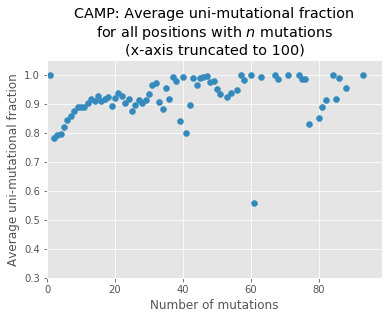

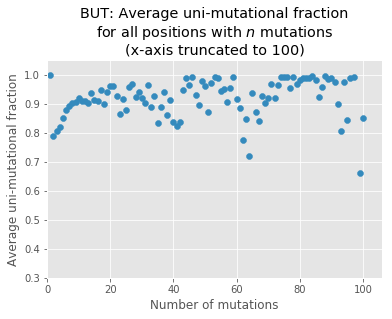

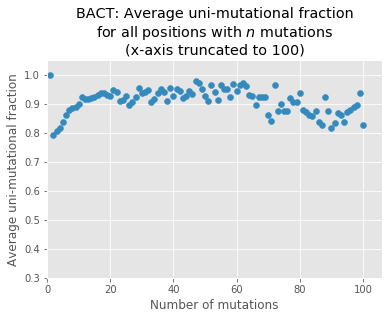

In [67]:
# plot # of mutations against average unimutational fraction
xlim_max = 100
for seq in SEQS:
    n2a = get_all_mutation_profile_data(seq)["num_mutations_to_avg_unimutational_fraction"]
    
    for i in range(0, xlim_max + 1):
        if type(n2a[i]) != str:
            pyplot.scatter(i, n2a[i], c=SCATTERPLOT_PT_COLOR)

    pyplot.xlabel("Number of mutations")
    pyplot.ylabel("Average uni-mutational fraction")

    title = "{}: Average uni-mutational fraction\nfor all positions with $n$ mutations".format(seq2name[seq])
    title += "\n(x-axis truncated to {})".format(xlim_max)
    pyplot.xlim(0)
    pyplot.ylim(0.3, 1.05)
    pyplot.title(title)
#     use_thousands_sep(pyplot.gca().xaxis)
    pyplot.show()

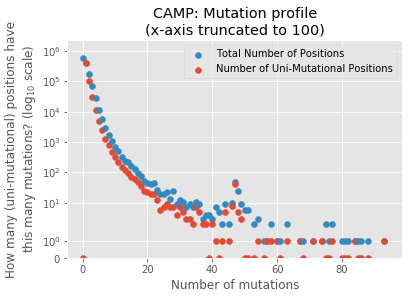

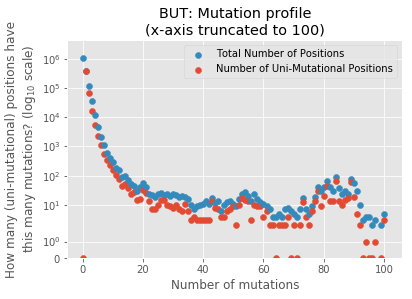

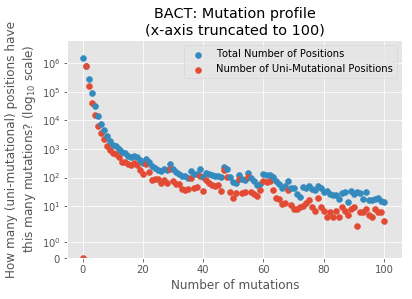

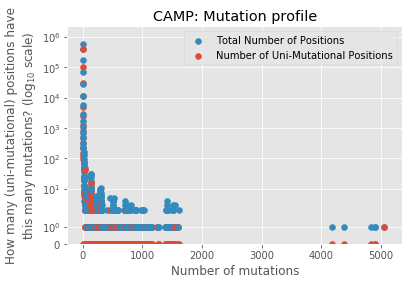

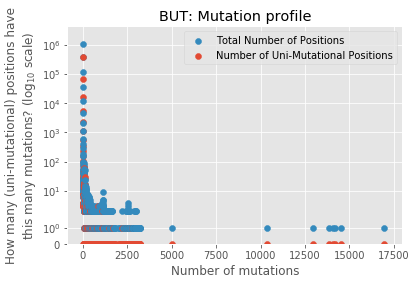

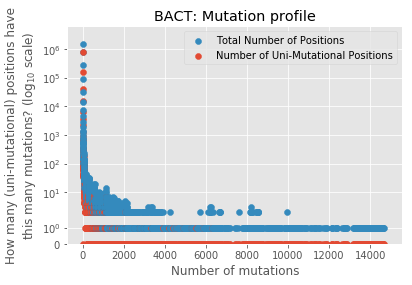

In [97]:
# plot mutation profiles: # of mutations against # of (uni-mutational) positions
# two variants of these, one with an x-max of 100 (to focus on "low" numbers of mutations)
# and another with no x-max
for xmax in [100, None]:
    for seq in SEQS:
        data = get_all_mutation_profile_data(seq)

        largest_mutct = max(data["num_mutations_to_freq"].keys()) if xmax is None else xmax
        for i in range(0, largest_mutct + 1):
            # Only plot #s of mutations with at least one occurrence
            if data["num_mutations_to_freq"][i] > 0:
                pyplot.scatter(i, data["num_mutations_to_freq"][i], c=SCATTERPLOT_PT_COLOR,
                               label="" if i > 0 else "Total Number of Positions")
                pyplot.scatter(i, data["num_mutations_to_unimutational_pos_ct"][i], c="#e24a33",
                               label="" if i > 0 else "Number of Uni-Mutational Positions")

        # Need to use symlog in order to 
        pyplot.yscale("symlog")
        pyplot.ylim(0)

        pyplot.xlabel("Number of mutations")        
        ylabel = "How many (uni-mutational) positions have\nthis many mutations?"
        ylabel += " (log$_{10}$ scale)"
        pyplot.ylabel(ylabel)

        title = "{}: Mutation profile".format(seq2name[seq])
        if xmax is not None: title += "\n(x-axis truncated to {})".format(xmax)
        pyplot.title(title)
        pyplot.legend()
        pyplot.show()

## Plot histograms of $\frac{N_1}{N_1 + N_2 + N_3}$ over all third-CP positions in each sequence

CAMP, CP 1: mean (valid, non-1) f-value = 0.5755627944868879, num valid non-1 f-values = 40,971


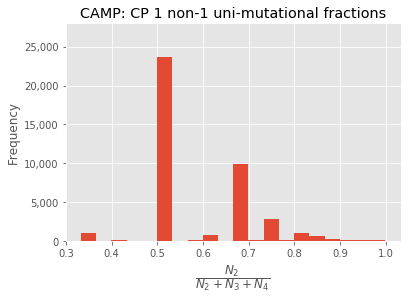

CAMP, CP 2: mean (valid, non-1) f-value = 0.5744063750208774, num valid non-1 f-values = 45,367


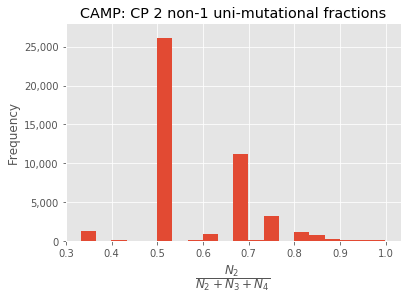

CAMP, CP 3: mean (valid, non-1) f-value = 0.5785083156769981, num valid non-1 f-values = 46,299


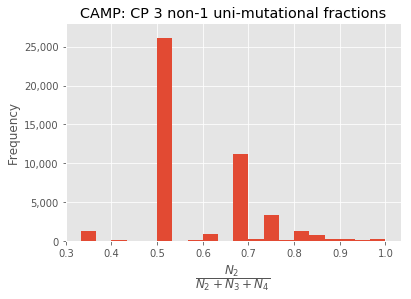

BUT, CP 1: mean (valid, non-1) f-value = 0.5617060306532969, num valid non-1 f-values = 22,553


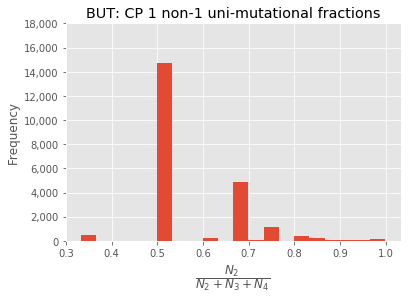

BUT, CP 2: mean (valid, non-1) f-value = 0.558715330107872, num valid non-1 f-values = 24,124


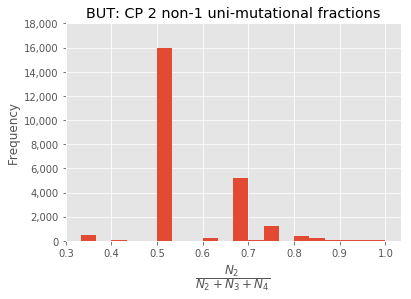

BUT, CP 3: mean (valid, non-1) f-value = 0.5635529009992281, num valid non-1 f-values = 25,765


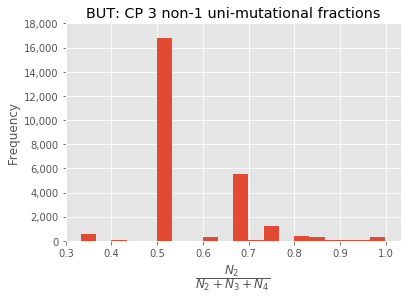

BACT, CP 1: mean (valid, non-1) f-value = 0.5738325931795382, num valid non-1 f-values = 53,134


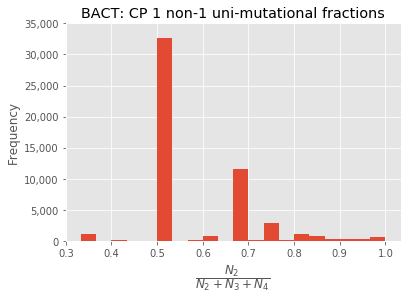

BACT, CP 2: mean (valid, non-1) f-value = 0.5677451941564228, num valid non-1 f-values = 54,083


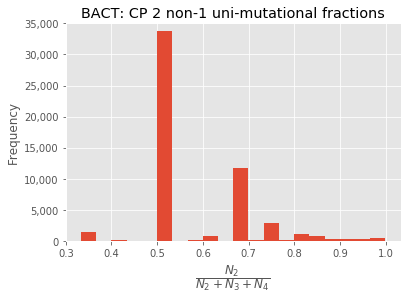

BACT, CP 3: mean (valid, non-1) f-value = 0.5962377732467788, num valid non-1 f-values = 54,717


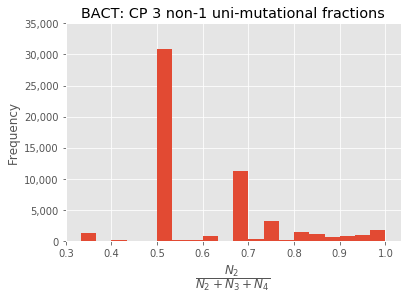

In [35]:
from parse_sco import parse_sco

for seq in SEQS:
    df = parse_sco(
        "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
    )
    # Go through each gene in this sequence. Find the (third) CPs. Record their "f" value, if present. Plot
    # a histogram of these f-values.
    num2fvals = {1: [], 2: [], 3: []}
    for gene in df.itertuples():
        i = 1
        for pos in get_pos_interval_from_gene(gene):
            f = seq2pos2f[seq][str(pos)]            
            if f is not None and f < 1:
                num2fvals[i].append(f)
            if i == 1:
                i = 2
            elif i == 2:
                i = 3
            elif i == 3:
                i = 1
            else:
                raise ValueError("Codon position modulo calculation is broken :|")

        if i != 1:
            raise ValueError("Gene length not divisible by 3.")
    
    for cp in [1, 2, 3]:
        print("{}, CP {}: mean (valid, non-1) f-value = {}, num valid non-1 f-values = {:,}".format(
            seq2name[seq], cp, mean(num2fvals[cp]), len(num2fvals[cp])
        ))
        pyplot.hist(num2fvals[cp], bins=20)
        pyplot.title("{}: CP {}".format(seq2name[seq], cp) + " non-1 uni-mutational fractions")
        pyplot.xlabel(r"$\dfrac{N_2}{N_2 + N_3 + N_4}$")
        pyplot.ylabel("Frequency")
        use_thousands_sep(pyplot.gca().yaxis)
        # This is a hack to make all CP plots in a row have the same y-axis. Ideally this'd be automatic
        # but uhhhh elbow grease is easier lol
        if seq2name[seq] == "CAMP":
            pyplot.ylim(0, 28000)
        elif seq2name[seq] == "BUT":
            pyplot.ylim(0, 18000)
        else:
            pyplot.ylim(0, 35000)
        pyplot.show()